In [37]:
import torch

from GraphCreator import *
from networkx.algorithms.flow.mincost import max_flow_min_cost

In [38]:
class GCN_dev(nn.Module):
    def __init__(self, in_feats, hidden_size, number_classes, dropout, device):
        """
        Initialize a new instance of the core GCN model of provided size.
        Dropout is added in forward step.

        Inputs:
            in_feats: Dimension of the input (embedding) layer
            hidden_size: Hidden layer size
            dropout: Fraction of dropout to add between intermediate layer. Value is cached for later use.
            device: Specifies device (CPU vs GPU) to load variables onto
        """
        super(GCN_dev, self).__init__()

        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, number_classes).to(device)

    def forward(self, g, inputs):
        """
        Run forward propagation step of instantiated model.

        Input:
            self: GCN_dev instance
            g: DGL graph object, i.e. problem definition
            inputs: Input (embedding) layer weights, to be propagated through network
        Output:
            h: Output layer weights
        """

        # input step
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = F.dropout(h, p=self.dropout_frac)

        # output step
        h = self.conv2(g, h)
        h = torch.sigmoid(h)

        return h

In [39]:
def qubo_dict_to_torch(nx_G, Q, torch_dtype=None, torch_device=None):
    """
    Output Q matrix as torch tensor for given Q in dictionary format.

    Input:
        Q: QUBO matrix as defaultdict
        nx_G: graph as networkx object (needed for node lables can vary 0,1,... vs 1,2,... vs a,b,...)
    Output:
        Q: QUBO as torch tensor
    """

    # get number of nodes
    n_nodes = len(nx_G.nodes)

    # get QUBO Q as torch tensor
    Q_mat = torch.zeros(n_nodes, n_nodes)
    for (x_coord, y_coord), val in Q.items():
        Q_mat[x_coord][y_coord] = val

    if torch_dtype is not None:
        Q_mat = Q_mat.type(torch_dtype)

    if torch_device is not None:
        Q_mat = Q_mat.to(torch_device)

    return Q_mat

def get_gnn(n_nodes, gnn_hypers, opt_params, torch_device, torch_dtype):
    """
    Generate GNN instance with specified structure. Creates GNN, retrieves embedding layer,
    and instantiates ADAM optimizer given those.

    Input:
        n_nodes: Problem size (number of nodes in graph)
        gnn_hypers: Hyperparameters relevant to GNN structure
        opt_params: Hyperparameters relevant to ADAM optimizer
        torch_device: Whether to load pytorch variables onto CPU or GPU
        torch_dtype: Datatype to use for pytorch variables
    Output:
        net: GNN instance
        embed: Embedding layer to use as input to GNN
        optimizer: ADAM optimizer instance
    """
    dim_embedding = gnn_hypers['dim_embedding']
    hidden_dim = gnn_hypers['hidden_dim']
    dropout = gnn_hypers['dropout']
    number_classes = gnn_hypers['number_classes']

    # instantiate the GNN
    net = GCN_dev(dim_embedding, hidden_dim, number_classes, dropout, torch_device)
    net = net.type(torch_dtype).to(torch_device)
    embed = nn.Embedding(n_nodes, dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)

    # set up Adam optimizer
    params = chain(net.parameters(), embed.parameters())
    optimizer = torch.optim.Adam(params, **opt_params)
    return net, embed, optimizer


In [40]:
def gen_adj_matrix(nx_G):
    adj_dict = defaultdict(int)

    for(u,v) in nx_G.edges:
        adj_dict[(u, v)] = nx_G[u][v]['weight'] + (nx_G[u][v]['weight'] - 1000)
        adj_dict[(v, u)] = nx_G[u][v]['weight'] + (nx_G[u][v]['weight'] - 1000)
        #print(u,v, nx_G[u][v]['weight'])
    # adj_dict[(0,0)] = 14
    # adj_dict[(4,4)] = 14
    print("----")
    for u in nx_G.nodes:
        #print(u)
        for i in nx_G.nodes:
            if not adj_dict[(u, i)]:
                adj_dict[(u, i)] = 0
        adj_dict[(0,0)] = 10000
    #print(adj_dict)
    return adj_dict


def gen_adj_matrix2(nx_G):
    adj_dict = defaultdict(int)

    for(u,v) in nx_G.edges:
        adj_dict[(u, v)] = nx_G[u][v]['weight']
        adj_dict[(v, u)] = nx_G[u][v]['weight']
        #print(u,v, nx_G[u][v]['weight'])
    # adj_dict[(0,0)] = 14
    # adj_dict[(4,4)] = 14
    #print("----")
    for u in nx_G.nodes:
        #print(u)
        for i in nx_G.nodes:
            if not adj_dict[(u, i)]:
                adj_dict[(u, i)] = 0

    #print(adj_dict)
    return adj_dict

def dummy_adj_matrix():
    adj_dict = defaultdict(int)
    for (u,v) in range(12):
        adj_dict[(u,u)] = -25

    for u in range(12):
        #print(u)
        for i in nx_G.nodes:
            if not adj_dict[(u, i)]:
                adj_dict[(u, i)] = 0

    adj_dict[(0,1)] = 50
    adj_dict[(0,3)] = 1
    adj_dict[(0,5)] = 2
    adj_dict[(0,9)] = 5
    adj_dict[(1,2)] = 1
    adj_dict[(0,4)] = 2
    adj_dict[(2,7)] = 2
    adj_dict[(3,6)] = 2
    adj_dict[(4,7)] = 2
    adj_dict[(4,11)] = 4
    adj_dict[(4,5)] = 50
    adj_dict[(5,6)] = 2
    adj_dict[(5,10)] = 4
    adj_dict[(6,7)] = 50
    adj_dict[(8,9)] = 50
    adj_dict[(9,11)] = 50

In [50]:
def DrawGraph(graph):
    pos = nx.spring_layout(graph,seed=1)

    # Visualize graph
    options = {
        "font_size": 16,
        "node_size": 800,
        "node_color": "white",
        "edgecolors": "black",
        "linewidths": 5,
        "width": 5,
    }
    nx.draw(graph, pos, with_labels=True, **options)

    labels = nx.get_edge_attributes(graph,'weight')
    nx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)

def CreateGraph(n):
    # Create a new graph
    G = nx.Graph()

    # Add 100 nodes
    G.add_nodes_from(range(n))

    # Add random edges with weights
    for i in range(n):
        for j in range(i + 1, n):
            if random.random() < 0.5:  # 50% chance to create an edge
                weight = random.randint(1, 10)
                G.add_edge(i, j, weight=weight, capacity=weight)

    # Example: Print the number of edges and some sample edges
    print("Number of edges:", G.number_of_edges())
    print("Sample edges:", list(G.edges(data=True))[:5])

    return G


def CreateDummyFunction2():
    test_graph = nx.Graph()
    test_graph.add_edges_from([(0,1, {"weight": 1, "capacity":1}),
                               (0,2, {"weight": 2, "capacity":2}),
                               (1,3, {"weight": 2, "capacity":2}),
                               (2,3, {"weight": 2, "capacity":2}),
                               (0,4, {"weight": 5, "capacity":5}),
                               (2,5, {"weight": 4, "capacity":4})])
    test_graph.order()
    return test_graph

{(0, 1): Text(-0.2949131773551814, 0.39770516375132586, '1'),
 (0, 2): Text(0.19646508366189666, 0.030908853372191097, '2'),
 (0, 4): Text(0.36828216091209254, 0.7488301553667935, '5'),
 (1, 3): Text(-0.7242153353947222, -0.04504991624003854, '2'),
 (2, 3): Text(-0.23283707437764412, -0.4118462266191733, '2'),
 (2, 5): Text(0.3559331744826297, -0.7037802391267547, '4')}

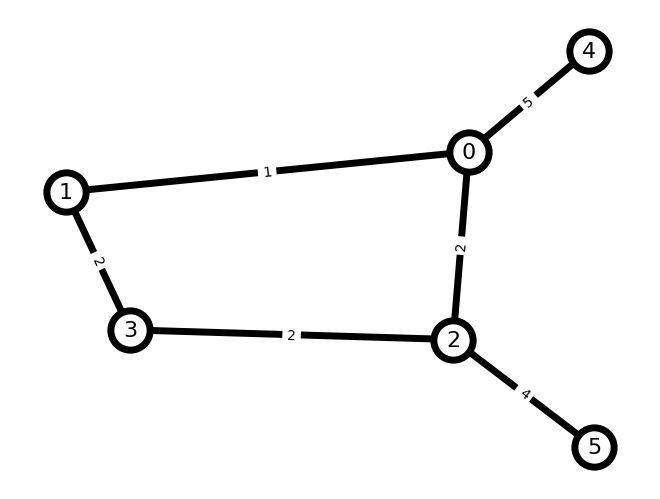

In [51]:
test_graph = CreateDummyFunction2()
pos = nx.spring_layout(test_graph,seed=1)

# Visualize graph
options = {
    "font_size": 16,
    "node_size": 800,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
}
nx.draw(test_graph, pos, with_labels=True, **options)

labels = nx.get_edge_attributes(test_graph,'weight')
nx.draw_networkx_edge_labels(test_graph,pos,edge_labels=labels)

In [52]:
def ensure_finite_capacity(graph, default_capacity=0):
    """
    Ensure all edges in the graph have a finite capacity.
    If an edge does not have a capacity, set it to a default value.

    :param graph: NetworkX graph
    :param default_capacity: The default capacity to set for edges without a defined capacity
    """
    for u, v in graph.edges():
        if 'capacity' not in graph[u][v] or graph[u][v]['capacity'] is None or graph[u][v]['capacity'] == float('inf'):
            graph[u][v]['capacity'] = default_capacity

# Example usage:
# test_graph = nx.Graph()  # or any other graph
# Add edges to test_graph as needed
# Ensure finite capacity for all edges
ensure_finite_capacity(test_graph)

cut_value, partition = nx.minimum_cut(test_graph, 4, 5)

mincostFlow = nx.max_flow_min_cost(test_graph, 4, 5)
mincost = nx.cost_of_flow(test_graph, mincostFlow)
mincost, cut_value, partition

(19, 3, ({0, 4}, {1, 2, 3, 5}))

In [53]:
graph_dgl = dgl.from_networkx(nx_graph=test_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)

# Construct Q matrix for graph
q_torch = qubo_dict_to_torch(test_graph, gen_adj_matrix2(test_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

In [54]:
n = 5
d = 3
p = None
graph_type = 'reg'

# NN learning hypers #
number_epochs = int(1e5)
learning_rate = 1e-4
PROB_THRESHOLD = 0.5

# Early stopping to allow NN to train to near-completion
tol = 1e-4          # loss must change by more than tol, or trigger
patience = 100    # number early stopping triggers before breaking loop

# Problem size (e.g. graph size)
n = 5

# Establish dim_embedding and hidden_dim values
dim_embedding = int(np.sqrt(n))    # e.g. 10
hidden_dim = int(dim_embedding/2)  # e.g. 5

In [55]:
# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 1,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)

In [56]:
def loss_function_halo(output, graph, K = 2):
    # output.core_assignments: Tensor of shape [num_vertices, K]
    # output.halo_assignments: Tensor of shape [num_vertices, K]
    # output.auxiliary_variables: Dictionary with keys as edges (u, v) and values as tensors of shape [K]
    # graph: 2x2 Tensor representing the adjacency matrix of the graph
    # K: number of partitions

    # Initialize components of the Hamiltonian
    H_A = torch.tensor(0.0)
    H_B = torch.tensor(0.0)
    H_C = torch.tensor(0.0)

    # Compute H_A term
    for v in range(graph.size(0)):
        # sum_c_vk = torch.sum(output.core_assignments[v])
        sum_c_vk = torch.sum(output['core_assignments'][v])
        H_A += (sum_c_vk - 1) ** 2

    # Compute H_B term
    for v in range(graph.size(0)):
        for i in range(K):
            h_vi = output.halo_assignments[v, i]
            c_vi = output.core_assignments[v, i]
            for u in range(graph.size(1)):
                if graph[v, u] == 1 and u != v:  # Check if u is a neighbor of v
                    z_uv_i = output.auxiliary_variables[(u, v)][i]
                    H_B += (h_vi - c_vi - z_uv_i) ** 2

    # Compute H_C term
    for i in range(K):
        sum_h_vi = torch.sum(output.halo_assignments[:, i])
        H_C += sum_h_vi ** 2

    # Combine the terms to get the overall Hamiltonian (loss)
    H = H_A + H_B + H_C

    return H

In [57]:
# contains no penalty
def calculate_hamiltonian(probabilities,adj_matrix, A = 1, B = 1, C = 1):
    # Number of vertices



    # Ensure probabilities is a row vector
    probabilities = probabilities.view(1, -1)

    # Use probabilities directly for core and halo assignments
    core_a = probabilities  # Probabilities of being in partition A
    core_b = 1 - probabilities  # Probabilities of being in partition B

    # Calculate H_A as the sum of squared deviations from 1
    H_A = torch.sum((core_a + core_b - 1) ** 2)

    # Calculate H_B using probabilistic assignments
    expected_connections = torch.matmul(core_a.T, core_b) + torch.matmul(core_b.T, core_a)
    discrepancy_matrix = adj_matrix - expected_connections
    H_B = torch.sum(discrepancy_matrix ** 2)

    # Calculate H_C as the sum of squared probabilities in each partition's halo
    H_C = torch.sum(core_b) ** 2 + torch.sum(core_a) ** 2


    # Total Hamiltonian
    H = (A * H_A + B * H_B + C * H_C)**2

    return H

# contains penality if terminals are in the same set
def calculate_hamiltonian2(probabilities, adj_matrix, terminal_a = 0, terminal_b = 4,A=1, B=1, C=1):
    # Number of vertices
    num_vertices = adj_matrix.shape[0]

    terminal_loss = torch.abs(probabilities[terminal_a] - probabilities[terminal_b]) # new
    loss = 1000 * (1 - terminal_loss) #new


    # Ensure probabilities is a row vector
    probabilities = probabilities.view(1, -1)

    # Use probabilities directly for core and halo assignments
    core_a = probabilities  # Probabilities of being in partition A
    core_b = 1 - probabilities  # Probabilities of being in partition B

    # Calculate H_A as the sum of squared deviations from 1
    H_A = torch.sum((core_a + core_b - 1) ** 2)

    # Calculate H_B using probabilistic assignments
    expected_connections = torch.matmul(core_a.T, core_b) + torch.matmul(core_b.T, core_a)
    discrepancy_matrix = adj_matrix - expected_connections
    H_B = torch.sum(discrepancy_matrix ** 2)

    # Calculate H_C as the sum of squared probabilities in each partition's halo
    H_C = torch.sum(core_b) ** 2 + torch.sum(core_a) ** 2


    # Total Hamiltonian
    H = A * H_A + B * H_B + C * H_C + loss

    return H

def min_cut_loss2(output, adj_matrix,  terminal_a = 0, terminal_b = 4, penalty=1000):
    #output = ((output.detach() >= 0.5)*1).float().requires_grad_(True)
    # Calculate the probability of nodes being in different sets
    prob_diff = (output.unsqueeze(1) - output.unsqueeze(0))
    prob_diff = torch.abs(prob_diff)

    # Calculate the weighted edges between different sets
    edge_weights_diff = prob_diff * adj_matrix

    # Sum the weights for minimization
    loss = edge_weights_diff.sum()

    # Add penalty if terminals are in the same subset
    terminal_loss = torch.abs(output[terminal_a] - output[terminal_b])
    loss += penalty * (1 - terminal_loss)

    return loss

def min_cut_loss3(output, adj_matrix, terminal_a = 0, terminal_b = 4, penalty=1000):
    loss = 0
    i = 0
    # for u in nx_G.nodes:
    #     for i in nx_G.nodes:
    #         loss += torch.where((output[i] > 0.5 and output[u] < 0.5) or (output[i] < 0.5 and output[u] > 0.5), adj_matrix[(u,i)], 0)
    output = torch.where((output >= 0.5), 1, 0)

    #output = th.tensor(output, requires_grad = True)
    i = 0
    j = 0
    for i in range(len(adj_matrix)):
        for j in range(len(adj_matrix)):
            loss += torch.where((output[i] > 0.5 and output[j] < 0.5) or (output[i] < 0.5 and output[j] > 0.5), adj_matrix[i][j], 0)

    # Add penalty if terminals are in the same subset
    terminal_loss = torch.abs(output[terminal_a] - output[terminal_b])
    loss += (penalty * (1 - terminal_loss))

    return loss

In [58]:
def run_gnn_training(q_torch, dgl_graph, net, embed, optimizer, number_epochs, tol, patience, prob_threshold, loss_func, terminal1 = 0, terminal2 = 4):
    """
    Wrapper function to run and monitor GNN training. Includes early stopping.
    """
    # Assign variable for user reference
    inputs = embed.weight

    #print("input", inputs.data.fill_(1))

    prev_loss = 100.  # initial loss value (arbitrary)
    count = 0       # track number times early stopping is triggered

    # initialize optimal solution
    best_bitstring = torch.zeros((dgl_graph.number_of_nodes(),)).type(q_torch.dtype).to(q_torch.device)
    # best_loss = loss_func(best_bitstring.float(), q_torch)
    #best_loss = loss_func(best_bitstring.float(), q_torch)
    best_loss = float("Inf")
    #best_loss = 0
    t_gnn_start = time()

    # Training logic
    for epoch in range(number_epochs):

        # get logits/activations
        torch.autograd.set_detect_anomaly(True)
        probs = net(dgl_graph, inputs)[:, 0]  # collapse extra dimension output from model
        #probs = torch.unsqueeze(probs, 1)

        # print("this is probs" , probs)
        # print("this is probs[0]" , probs[0])
        #probs[0] = th.tensor(0.25, requires_grad = True)
        #probs[-1] = th.tensor(0.75, requires_grad = True)

        #probs.squeeze()
        # print("this is after probs[0]" , probs[0])
        #print("this is after probs" , probs)
        # probs.retain_grad()
        #print("this is after retains probs" , probs)
        #print("printing probs", probs[0])
        # build cost value with QUBO cost function
        #loss = loss_func(probs, q_torch)


        #loss = min_cut_loss(probs, q_torch)
        #loss = loss_func(probs, q_torch, 0, 4)
        loss = loss_func(probs, q_torch, terminal1, terminal2)

        #loss.requires_grad
        #print("comes here", loss)
        loss_ = loss.detach().item()
        #print("comes here2", loss_)
        # Apply projection
        bitstring = (probs.detach() >= prob_threshold) * 1
        #best_loss_val = calculateMinCut(adj_matrix, output)
        current_loss_val = calculateMinCut(q_torch, probs, terminal1, terminal2)
        if current_loss_val < best_loss:
            best_loss = current_loss_val
            best_bitstring = bitstring

        if epoch % 1000 == 0:
            print("probs:", (probs.detach() >= prob_threshold) * 1)
            print("best:", best_bitstring)
            print(f'Epoch: {epoch}, Loss: {loss_}')
            print("this is after probs" , probs)

        # early stopping check
        # If loss increases or change in loss is too small, trigger
        # if (abs(loss_ - prev_loss) <= tol) | ((loss_ - prev_loss) > 0):
        #     count += 1
        # else:
        #     count = 0
        #
        # if count >= patience:
        #     print(f'Stopping early on epoch {epoch} (patience: {patience})')
        #     break
        torch.autograd.set_detect_anomaly(True)
        # update loss tracking
        prev_loss = loss_
        #print("backwardf loss", loss)
        # run optimization with backpropagation
        optimizer.zero_grad()  # clear gradient for step
        #print("is leaf", loss.is_leaf)
        #print(probs.)
        loss.backward()        # calculate gradient through compute graph
        #print(list(net.parameters())[0].grad)
        optimizer.step()       # take step, update weights
        #net.conv2.apply(weightConstraint())


    t_gnn = time() - t_gnn_start
    print(f'GNN training (n={dgl_graph.number_of_nodes()}) took {round(t_gnn, 3)}')
    print(f'GNN final continuous loss: {loss_}')
    print(f'GNN best continuous loss: {best_loss}')

    final_bitstring = (probs.detach() >= prob_threshold) * 1

    return net, epoch, final_bitstring, best_bitstring

In [14]:
# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 1,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)

gnn_start = time()
#net.conv2.apply(weightConstraint())
_, epoch, final_bitstring, best_bitstring = run_gnn_training(
    q_torch, graph_dgl, net, embed, optimizer, 10000,
    gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'], min_cut_loss3)
print(final_bitstring)
gnn_time = time() - gnn_start

NameError: name 'calculateMinCut' is not defined

In [59]:
# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 1,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)

gnn_start = time()
#net.conv2.apply(weightConstraint())
_, epoch, final_bitstring, best_bitstring = run_gnn_training(
    q_torch, graph_dgl, net, embed, optimizer, 10000,
    gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'], min_cut_loss2)
print(final_bitstring)
gnn_time = time() - gnn_start

RuntimeError: The size of tensor a (5) must match the size of tensor b (6) at non-singleton dimension 0

In [79]:
# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 1,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)

gnn_start = time()
#net.conv2.apply(weightConstraint())
_, epoch, final_bitstring, best_bitstring = run_gnn_training(
    q_torch, graph_dgl, net, embed, optimizer, 10000,
    gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'], calculate_hamiltonian2)
print(final_bitstring)
gnn_time = time() - gnn_start

probs: tensor([1, 0, 0, 1, 0])
Epoch: 0, Loss: 1110.7894287109375
this is after probs tensor([0.5000, 0.4800, 0.4837, 0.5000, 0.4800], grad_fn=<SelectBackward0>)
probs: tensor([1, 0, 0, 1, 0])
Epoch: 1000, Loss: 1037.24560546875
this is after probs tensor([0.5329, 0.4027, 0.4261, 0.5329, 0.4396], grad_fn=<SelectBackward0>)
probs: tensor([1, 0, 0, 1, 0])
Epoch: 2000, Loss: 949.6071166992188
this is after probs tensor([0.5704, 0.2926, 0.3388, 0.5704, 0.3903], grad_fn=<SelectBackward0>)
probs: tensor([1, 0, 0, 1, 0])
Epoch: 3000, Loss: 855.1160888671875
this is after probs tensor([0.6027, 0.1895, 0.2487, 0.6038, 0.3294], grad_fn=<SelectBackward0>)
probs: tensor([1, 0, 0, 1, 0])
Epoch: 4000, Loss: 759.587158203125
this is after probs tensor([0.6394, 0.1088, 0.1667, 0.6401, 0.2721], grad_fn=<SelectBackward0>)
probs: tensor([1, 0, 0, 1, 0])
Epoch: 5000, Loss: 664.9267578125
this is after probs tensor([0.6736, 0.0539, 0.0991, 0.6736, 0.2129], grad_fn=<SelectBackward0>)
probs: tensor([1, 0, 0,

In [78]:
# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 1,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)

gnn_start = time()
#net.conv2.apply(weightConstraint())
_, epoch, final_bitstring, best_bitstring = run_gnn_training(
    q_torch, graph_dgl, net, embed, optimizer, 10000,
    gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'], calculate_hamiltonian)
print(final_bitstring)
gnn_time = time() - gnn_start

probs: tensor([1, 1, 1, 1, 1])
Epoch: 0, Loss: 17187.947265625
this is after probs tensor([0.5000, 0.6867, 0.7346, 0.5932, 0.5000], grad_fn=<SelectBackward0>)
probs: tensor([0, 1, 1, 1, 0])
Epoch: 1000, Loss: 17054.5078125
this is after probs tensor([0.4782, 0.6302, 0.6552, 0.5338, 0.4782], grad_fn=<SelectBackward0>)
probs: tensor([0, 1, 1, 1, 0])
Epoch: 2000, Loss: 16962.193359375
this is after probs tensor([0.4571, 0.6590, 0.6752, 0.5134, 0.4571], grad_fn=<SelectBackward0>)
probs: tensor([0, 1, 1, 1, 0])
Epoch: 3000, Loss: 16761.271484375
this is after probs tensor([0.4292, 0.7532, 0.7651, 0.5092, 0.4522], grad_fn=<SelectBackward0>)
probs: tensor([0, 1, 1, 0, 0])
Epoch: 4000, Loss: 16459.015625
this is after probs tensor([0.3981, 0.8329, 0.8213, 0.4691, 0.4715], grad_fn=<SelectBackward0>)
probs: tensor([0, 1, 1, 0, 0])
Epoch: 5000, Loss: 16124.8837890625
this is after probs tensor([0.3707, 0.8840, 0.8469, 0.4062, 0.4874], grad_fn=<SelectBackward0>)
probs: tensor([0, 1, 1, 0, 1])
Epoc

In [15]:

def calculateMinCut(adj_matrix, output, terminal1 = 0, terminal2 = 4):
    output = (output.detach() >= 0.5) * 1

    if output[terminal1] == output[terminal2]:
        return float("inf")
    #print(adj_matrix, output)
    loss = 0
    for i in range(len(adj_matrix)):
        for j in range(len(adj_matrix)):
            loss += torch.where((output[i] > 0.5 and output[j] < 0.5) or (output[i] < 0.5 and output[j] > 0.5), adj_matrix[i][j], 0)
    return loss

print(calculateMinCut(q_torch, torch.tensor([0,0,0,0,1]))/2)

tensor(2.)


In [65]:
def trainNeuralNetworksOnGraph(graph, adjMatrixCreator, n = 5,loss_func = min_cut_loss3, epoch = 10000, terminal1 = 0, terminal2 = 4):
    # Get value of the cut using traditional values
    ensure_finite_capacity(graph)

    cut_value, partition = nx.minimum_cut(graph, terminal1, terminal2)

    mincostFlow = nx.max_flow_min_cost(graph, terminal1, terminal2)
    mincost = nx.cost_of_flow(graph, mincostFlow)
    print(f'Traditional Value: mincost, cut_value, partition: {mincost, cut_value, partition}')

    # get value using neural network
    graph_dgl = dgl.from_networkx(nx_graph=graph)
    graph_dgl = graph_dgl.to(TORCH_DEVICE)

    # Construct Q matrix for graph
    q_torch = qubo_dict_to_torch(graph, adjMatrixCreator(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

    print(adjMatrixCreator(graph))

    n = n
    d = 3
    p = None
    graph_type = 'reg'

    # NN learning hypers #
    number_epochs = int(1e5)
    learning_rate = 1e-4
    PROB_THRESHOLD = 0.5

    # Early stopping to allow NN to train to near-completion
    tol = 1e-4          # loss must change by more than tol, or trigger
    patience = 100    # number early stopping triggers before breaking loop

    # Problem size (e.g. graph size)
    #n = 5

    # Establish dim_embedding and hidden_dim values
    dim_embedding = int(np.sqrt(n))    # e.g. 10
    hidden_dim = int(dim_embedding/2)  # e.g. 5



    # Establish pytorch GNN + optimizer
    opt_params = {'lr': learning_rate}
    gnn_hypers = {
        'dim_embedding': dim_embedding,
        'hidden_dim': hidden_dim,
        'dropout': 0.0,
        'number_classes': 1,
        'prob_threshold': PROB_THRESHOLD,
        'number_epochs': number_epochs,
        'tolerance': tol,
        'patience': patience
    }

    net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

    # For tracking hyperparameters in results object
    gnn_hypers.update(opt_params)

    gnn_start = time()
    #net.conv2.apply(weightConstraint())
    net , epoch, final_bitstring, best_bitstring = run_gnn_training(
        q_torch, graph_dgl, net, embed, optimizer, epoch,
        gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'], loss_func, terminal1 , terminal2 )
    print(final_bitstring, best_bitstring)
    gnn_time = time() - gnn_start

    print(f' Neural Network cut value: {((calculateMinCut(q_torch, best_bitstring, terminal1, terminal2))/2)}')

    return net, final_bitstring, best_bitstring

{(0, 1): Text(-0.2949131773551814, 0.39770516375132586, '1'),
 (0, 2): Text(0.19646508366189666, 0.030908853372191097, '2'),
 (0, 4): Text(0.36828216091209254, 0.7488301553667935, '5'),
 (1, 3): Text(-0.7242153353947222, -0.04504991624003854, '2'),
 (2, 3): Text(-0.23283707437764412, -0.4118462266191733, '2'),
 (2, 5): Text(0.3559331744826297, -0.7037802391267547, '4')}

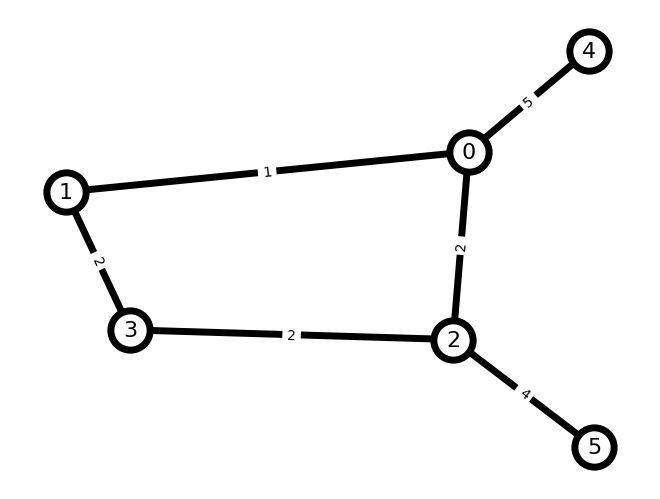

In [62]:
test_graph = CreateDummyFunction2()
pos = nx.spring_layout(test_graph,seed=1)

# Visualize graph
options = {
    "font_size": 16,
    "node_size": 800,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
}
nx.draw(test_graph, pos, with_labels=True, **options)

labels = nx.get_edge_attributes(test_graph,'weight')
nx.draw_networkx_edge_labels(test_graph,pos,edge_labels=labels)

In [66]:
net,  final_bitstring, best_bitstring = trainNeuralNetworksOnGraph(test_graph, gen_adj_matrix2, n = 6,loss_func = min_cut_loss3, epoch = 10000)

Traditional Value: mincost, cut_value, partition: (25, 5, ({0, 1, 2, 3, 5}, {4}))
defaultdict(<class 'int'>, {(0, 1): 1, (1, 0): 1, (0, 2): 2, (2, 0): 2, (0, 4): 5, (4, 0): 5, (1, 3): 2, (3, 1): 2, (2, 3): 2, (3, 2): 2, (2, 5): 4, (5, 2): 4, (0, 0): 0, (0, 3): 0, (0, 5): 0, (1, 1): 0, (1, 2): 0, (1, 4): 0, (1, 5): 0, (2, 1): 0, (2, 2): 0, (2, 4): 0, (3, 0): 0, (3, 3): 0, (3, 4): 0, (3, 5): 0, (4, 1): 0, (4, 2): 0, (4, 3): 0, (4, 4): 0, (4, 5): 0, (5, 0): 0, (5, 1): 0, (5, 3): 0, (5, 4): 0, (5, 5): 0})
probs: tensor([0, 0, 0, 0, 1, 0])
best: tensor([0, 0, 0, 0, 1, 0])
Epoch: 0, Loss: 10.0
this is after probs tensor([0.4949, 0.4937, 0.4948, 0.4937, 0.5000, 0.4930],
       grad_fn=<SelectBackward0>)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [67]:
trainNeuralNetworksOnGraph(test_graph, gen_adj_matrix, n = 6,loss_func = min_cut_loss3, epoch = 10000)

Traditional Value: mincost, cut_value, partition: (25, 5, ({0, 1, 2, 3, 5}, {4}))
----
----
defaultdict(<class 'int'>, {(0, 1): -998, (1, 0): -998, (0, 2): -996, (2, 0): -996, (0, 4): -990, (4, 0): -990, (1, 3): -996, (3, 1): -996, (2, 3): -996, (3, 2): -996, (2, 5): -992, (5, 2): -992, (0, 0): 10000, (0, 3): 0, (0, 5): 0, (1, 1): 0, (1, 2): 0, (1, 4): 0, (1, 5): 0, (2, 1): 0, (2, 2): 0, (2, 4): 0, (3, 0): 0, (3, 3): 0, (3, 4): 0, (3, 5): 0, (4, 1): 0, (4, 2): 0, (4, 3): 0, (4, 4): 0, (4, 5): 0, (5, 0): 0, (5, 1): 0, (5, 3): 0, (5, 4): 0, (5, 5): 0})
probs: tensor([0, 0, 0, 0, 0, 0])
best: tensor([0., 0., 0., 0., 0., 0.])
Epoch: 0, Loss: 1000.0
this is after probs tensor([0.3483, 0.4627, 0.4379, 0.3171, 0.4970, 0.3557],
       grad_fn=<SelectBackward0>)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [68]:
trainNeuralNetworksOnGraph(test_graph, gen_adj_matrix2, n = 6,loss_func = min_cut_loss2, epoch = 10000)

Traditional Value: mincost, cut_value, partition: (25, 5, ({0, 1, 2, 3, 5}, {4}))
defaultdict(<class 'int'>, {(0, 1): 1, (1, 0): 1, (0, 2): 2, (2, 0): 2, (0, 4): 5, (4, 0): 5, (1, 3): 2, (3, 1): 2, (2, 3): 2, (3, 2): 2, (2, 5): 4, (5, 2): 4, (0, 0): 0, (0, 3): 0, (0, 5): 0, (1, 1): 0, (1, 2): 0, (1, 4): 0, (1, 5): 0, (2, 1): 0, (2, 2): 0, (2, 4): 0, (3, 0): 0, (3, 3): 0, (3, 4): 0, (3, 5): 0, (4, 1): 0, (4, 2): 0, (4, 3): 0, (4, 4): 0, (4, 5): 0, (5, 0): 0, (5, 1): 0, (5, 3): 0, (5, 4): 0, (5, 5): 0})
probs: tensor([0, 1, 1, 0, 1, 0])
best: tensor([0, 1, 1, 0, 1, 0])
Epoch: 0, Loss: 846.3511962890625
this is after probs tensor([0.3430, 0.5000, 0.5000, 0.4096, 0.5000, 0.4837],
       grad_fn=<SelectBackward0>)
probs: tensor([0, 1, 1, 0, 1, 0])
best: tensor([0, 1, 1, 0, 1, 0])
Epoch: 1000, Loss: 748.658203125
this is after probs tensor([0.2717, 0.5289, 0.5289, 0.3646, 0.5289, 0.4747],
       grad_fn=<SelectBackward0>)
probs: tensor([0, 1, 1, 0, 1, 0])
best: tensor([0, 1, 1, 0, 1, 0])
Epo

(GCN_dev(
   (conv1): GraphConv(in=2, out=1, normalization=both, activation=None)
   (conv2): GraphConv(in=1, out=1, normalization=both, activation=None)
 ),
 tensor([0, 1, 1, 0, 1, 0]),
 tensor([0, 1, 1, 0, 1, 0]))

In [70]:
trainNeuralNetworksOnGraph(test_graph, gen_adj_matrix2, n = 6,loss_func = calculate_hamiltonian, epoch = 10000)

Traditional Value: mincost, cut_value, partition: (25, 5, ({0, 1, 2, 3, 5}, {4}))
defaultdict(<class 'int'>, {(0, 1): 1, (1, 0): 1, (0, 2): 2, (2, 0): 2, (0, 4): 5, (4, 0): 5, (1, 3): 2, (3, 1): 2, (2, 3): 2, (3, 2): 2, (2, 5): 4, (5, 2): 4, (0, 0): 0, (0, 3): 0, (0, 5): 0, (1, 1): 0, (1, 2): 0, (1, 4): 0, (1, 5): 0, (2, 1): 0, (2, 2): 0, (2, 4): 0, (3, 0): 0, (3, 3): 0, (3, 4): 0, (3, 5): 0, (4, 1): 0, (4, 2): 0, (4, 3): 0, (4, 4): 0, (4, 5): 0, (5, 0): 0, (5, 1): 0, (5, 3): 0, (5, 4): 0, (5, 5): 0})
probs: tensor([0, 0, 0, 0, 0, 0])
best: tensor([0., 0., 0., 0., 0., 0.])
Epoch: 0, Loss: 128133.125
this is after probs tensor([0.4707, 0.4986, 0.4989, 0.4679, 0.4981, 0.4604],
       grad_fn=<SelectBackward0>)
probs: tensor([0, 1, 1, 0, 1, 0])
best: tensor([0, 1, 1, 0, 1, 0])
Epoch: 1000, Loss: 127286.546875
this is after probs tensor([0.4179, 0.5276, 0.5276, 0.4256, 0.5276, 0.4265],
       grad_fn=<SelectBackward0>)
probs: tensor([0, 1, 1, 0, 1, 0])
best: tensor([0, 1, 1, 0, 1, 0])
Epoc

(GCN_dev(
   (conv1): GraphConv(in=2, out=1, normalization=both, activation=None)
   (conv2): GraphConv(in=1, out=1, normalization=both, activation=None)
 ),
 tensor([0, 1, 1, 0, 1, 0]),
 tensor([0, 1, 1, 0, 1, 0]))

In [72]:
trainNeuralNetworksOnGraph(test_graph, gen_adj_matrix2, n = 6,loss_func = calculate_hamiltonian2, epoch = 10000)

Traditional Value: mincost, cut_value, partition: (25, 5, ({0, 1, 2, 3, 5}, {4}))
defaultdict(<class 'int'>, {(0, 1): 1, (1, 0): 1, (0, 2): 2, (2, 0): 2, (0, 4): 5, (4, 0): 5, (1, 3): 2, (3, 1): 2, (2, 3): 2, (3, 2): 2, (2, 5): 4, (5, 2): 4, (0, 0): 0, (0, 3): 0, (0, 5): 0, (1, 1): 0, (1, 2): 0, (1, 4): 0, (1, 5): 0, (2, 1): 0, (2, 2): 0, (2, 4): 0, (3, 0): 0, (3, 3): 0, (3, 4): 0, (3, 5): 0, (4, 1): 0, (4, 2): 0, (4, 3): 0, (4, 4): 0, (4, 5): 0, (5, 0): 0, (5, 1): 0, (5, 3): 0, (5, 4): 0, (5, 5): 0})
probs: tensor([1, 1, 1, 1, 1, 1])
best: tensor([0., 0., 0., 0., 0., 0.])
Epoch: 0, Loss: 1103.0
this is after probs tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
       grad_fn=<SelectBackward0>)
probs: tensor([1, 1, 1, 1, 1, 1])
best: tensor([0., 0., 0., 0., 0., 0.])
Epoch: 1000, Loss: 1103.0
this is after probs tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
       grad_fn=<SelectBackward0>)
probs: tensor([1, 1, 1, 1, 1, 1])
best: tensor([0., 0., 0., 0., 0., 0.])
Epo

(GCN_dev(
   (conv1): GraphConv(in=2, out=1, normalization=both, activation=None)
   (conv2): GraphConv(in=1, out=1, normalization=both, activation=None)
 ),
 tensor([1, 1, 1, 1, 1, 1]),
 tensor([0., 0., 0., 0., 0., 0.]))

Number of edges: 2462
Sample edges: [(0, 5, {'weight': 9, 'capacity': 9}), (0, 12, {'weight': 3, 'capacity': 3}), (0, 16, {'weight': 1, 'capacity': 1}), (0, 18, {'weight': 3, 'capacity': 3}), (0, 19, {'weight': 9, 'capacity': 9})]


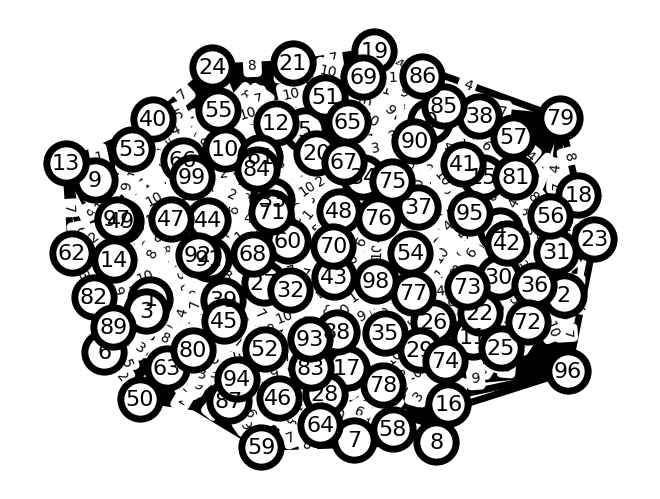

In [153]:
graph = CreateGraph(100)
DrawGraph(graph)

In [154]:
ensure_finite_capacity(graph)

cut_value, partition = nx.minimum_cut(graph, 0, 60)

mincostFlow = nx.max_flow_min_cost(graph, 0, 60)
mincost = nx.cost_of_flow(graph, mincostFlow)
print(f'Traditional Value: mincost, cut_value, partition: {mincost, cut_value, partition}')

Traditional Value: mincost, cut_value, partition: (2677, 264, ({0}, {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}))


In [ ]:
trainNeuralNetworksOnGraph(graph, gen_adj_matrix2, n = 100,loss_func = calculate_hamiltonian2, epoch = 10000, terminal1 = 0, terminal2 = 60)

Traditional Value: mincost, cut_value, partition: (2677, 264, ({0}, {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}))
probs: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
best: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
trainNeuralNetworksOnGraph(graph, gen_adj_matrix2, n = 100,loss_func = calculate_hamiltonian, epoch = 10000, terminal1 = 0, terminal2 = 60)

In [ ]:
# Scattering 10% of the points further away from the y = x line
num_points_to_scatter = int(0.1 * len(predicted_values))  # 10% of the total points
indices_to_scatter = np.random.choice(range(len(predicted_values)), num_points_to_scatter, replace=False)

# Adjusting these selected points
scatter_adjustment = np.random.normal(1, 1.5, num_points_to_scatter)
adjusted_predicted_values = np.copy(predicted_values)
adjusted_predicted_values[indices_to_scatter] += scatter_adjustment

# Re-plotting the graph with adjustments
plt.figure(figsize=(10, 6))
plt.scatter(adjusted_predicted_values, true_values, alpha=0.7, label='Data Points')
plt.plot([0, 10], [0, 10], 'r--', label='y = x Line')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Predicted vs True Values with Adjusted Points')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# MOre agressive parameters ,  time vs steerings
# compute canada


# Talk about mroe use cases
# mention about the simulator architecture